In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import numpy as np
import cv2
from PIL import Image

import os
from options.test_options import TestOptions
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
# from util.visualizer import save_images
from util import html
import torch
import torchvision
import torchvision.transforms as transforms

from helper_demo import helper

# Face to cartoon
The images from the real face dataset are very well illuminated and taken by a qualitative setup. Images from the testset are transformed very well to cartoons. To show a real-world performance we run webcam images through the network to see if they still produce an output.

In the first part we have to setup our model and load the weights. We provide pretrained networks for different lambdas and a demo option where we have picked the best models we got.

Then we use opencv to capture the video camera and matplotlib to show the current conversions. To stop the loop you have to interrupt the (Jupyter) Kernel.

In order to use the bonus part you have to download and install the full dataset.

Have fun.

### Load the model

In [2]:
# setup cyclegan model using the training options
opt = helper.setup_options()

# we provide different pretrained models
#opt.name="cartoonfaces"           #landmark lambda of 0.001
#opt.name="cartoonfaces-ld0_0001"  #landmark lambda of 0.0001
#opt.name="cartoonfaces-ld0_00001" #landmark lambda of 0.00001
#opt.name="cartoonfaces-ld0_0"     #landmark lambda of 0.0
#opt.name="demo"                    #best choice for G_A and G_B.
opt.name = "goblin"

model = create_model(opt)
model.isTrain = False
model.setup(opt)


----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/faces              
             dataset_mode: face                          
                direction: AtoB                          
              display_env: main                          
             display_freq: 100                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1  

### Convert faces to cartoons (forward pass through the network)

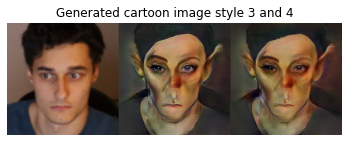

In [3]:
from IPython.display import clear_output

# control the "zoom" with the framesize:
# 256x256 will be cropped out from the center.
# use this as initial frame size:
framesize = 500

# capture on webcam
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1);

# use the hflip for "demirrored" webcams
transform = transforms.Compose([torchvision.transforms.functional.hflip,
                                transforms.CenterCrop(256),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])

style = 0
style2 = 1
style_counter = True

try:
    while(True):
        # drop capture buffer (the easy way)
        ret, frame = cap.read()
        ret, frame = cap.read()
        ret, frame = cap.read()
        
        # update style
        if style_counter:
            style = ((style + 1) % 10)
            style2 = ((style2 + 1) % 10)

        # scale the image and convert to RGB
        hight, width, depth = frame.shape
        crop_pixel = int((width - hight)/2) # crop square
        cropped_frame = frame[:, crop_pixel:width-crop_pixel]
        resized_frame = cv2.resize(cropped_frame, (framesize, framesize))
        cvframe = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB) 
        
        # transform the capture to an PIL image
        pil_img = Image.fromarray(cvframe)
        img = transform(pil_img)
        img = img.view(1, 3, 256, 256)
        img_A = helper.to_image(img)
        
        img_B = model.gen_B(img, style+1)
        img_B2 = model.gen_B(img, style2+1)
        img_B = helper.to_image(img_B)
        img_B2 = helper.to_image(img_B2)
        img_AB = helper.concatenate([img_A, img_B, img_B2])
        img_AB.save('comic.jpg')
        
        clear_output()
        plt.axis('off')
        plt.title('Generated cartoon image style {} and {}'.format(style+1, style2+1))
        plt.imshow(img_AB)
        plt.show()        
    
except KeyboardInterrupt:
    # you have to interrupt the kernel to break the loop:
    cap.release()
   


In [7]:
cap.release()

If the image is too dark, put a lamp in front of your face. This improves the overall illumination.

### Visualize training data
To run this part you need to setup the dataset. Instructions are under `../README.md`.

In [5]:
# setup dataset
dataset = create_dataset(opt)

# and some real faces from the dataset
for i, data in enumerate(dataset):
    if (i > 5):
        break
    
    theA = data['A']
    real_A = theA['img']
    img_A = helper.to_image(real_A)
    img_B = model.gen_B(real_A, (i%10)+1)
    img_B = helper.to_image(img_B)
    img_AB = helper.concatenate([img_A, img_B])
    img_AB.save('comic2.jpg')
    
    plt.axis('off')
    plt.title('Generated comic image')
    plt.imshow(img_AB)
    plt.show()

AssertionError: ./datasets/faces\test is not a valid directory

### Bonus: convert cartoons to faces


In [ ]:
for i, data in enumerate(dataset):
    if (i > 5):
        break
    
    theB = data['B']
    real_B = theB['img']
    img_B = helper.to_image(real_B)
    img_A = model.gen_A(real_B)
    img_A = helper.to_image(img_A)
    img_BA = helper.concatenate([img_B, img_A])
    img_BA.save('real.jpg')
    
    plt.axis('off')
    plt.title('Generated face image')
    plt.imshow(img_BA)
    plt.show()
    